In [1]:
import tensorflow as tf
tf.__version__

'2.9.2'

# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs


Deep Convolutional Generative Adversarial Networks, DCGAN
     

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(
    train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    # Note: None is the batch size
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(
        128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
              padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

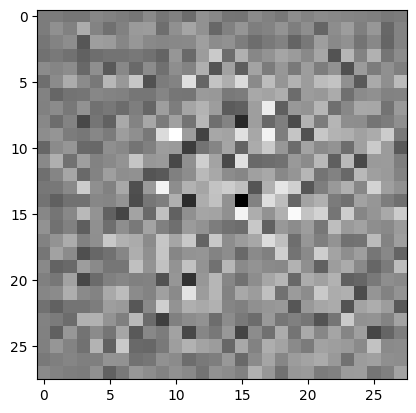

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00376918]], shape=(1, 1), dtype=float32)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
#        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

    # Generate after the final epoch
#    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.close()

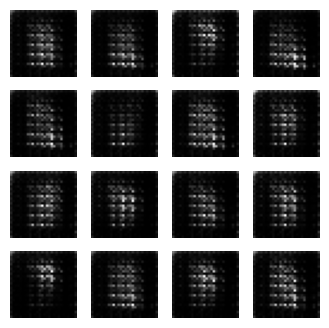

Time for epoch 1 is 11.979536533355713 sec


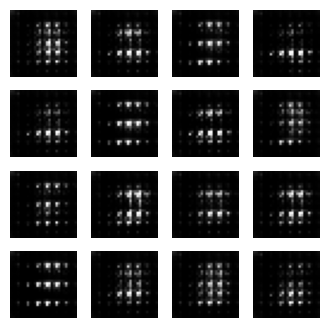

Time for epoch 2 is 10.433088302612305 sec


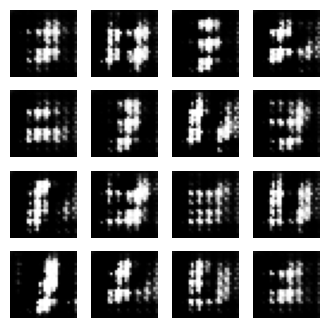

Time for epoch 3 is 10.367759704589844 sec


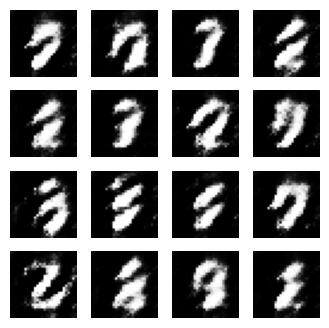

Time for epoch 4 is 10.459858894348145 sec


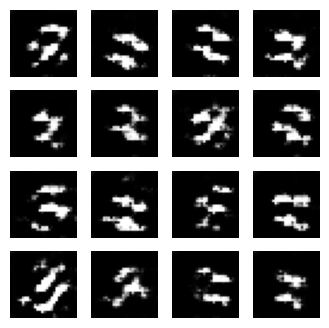

Time for epoch 5 is 10.388964653015137 sec


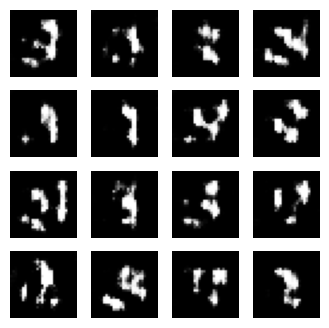

Time for epoch 6 is 10.403034448623657 sec


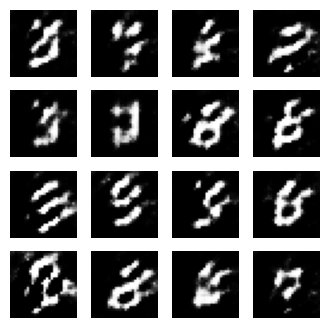

Time for epoch 7 is 10.54221487045288 sec


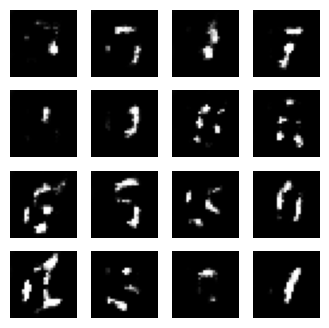

Time for epoch 8 is 10.497817516326904 sec


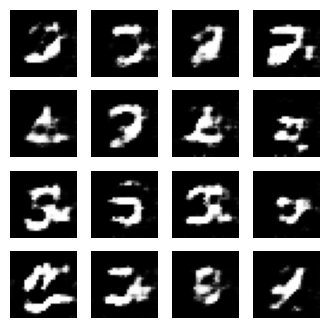

Time for epoch 9 is 10.489237070083618 sec


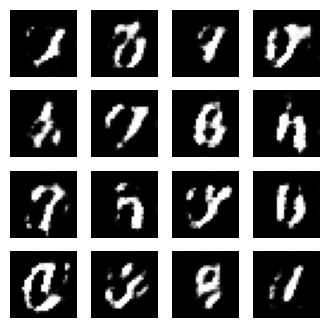

Time for epoch 10 is 10.399930953979492 sec


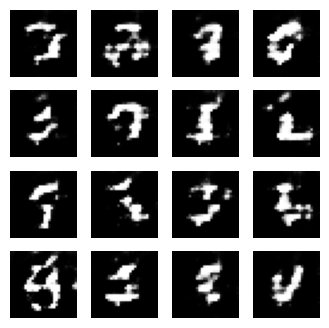

Time for epoch 11 is 10.498805284500122 sec


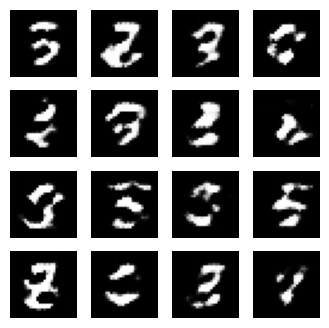

Time for epoch 12 is 10.36697506904602 sec


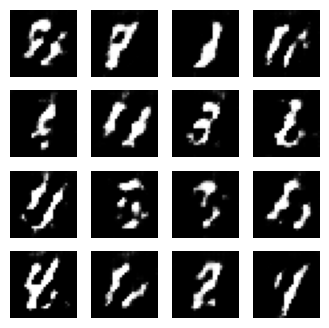

Time for epoch 13 is 10.419622898101807 sec


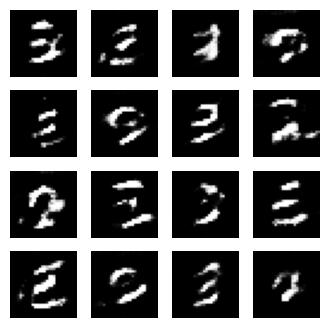

Time for epoch 14 is 10.539726495742798 sec


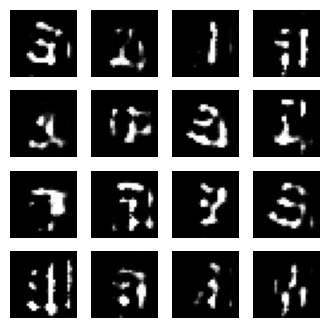

Time for epoch 15 is 10.485565900802612 sec


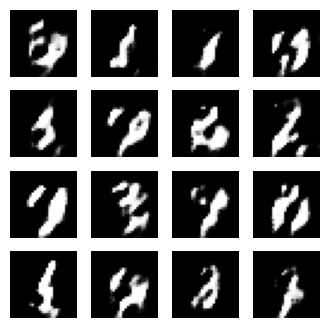

Time for epoch 16 is 10.508496522903442 sec


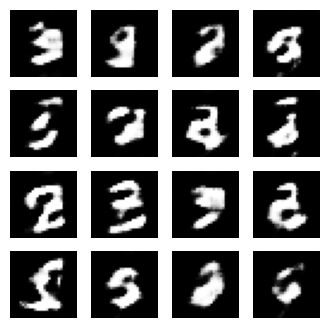

Time for epoch 17 is 10.519793510437012 sec


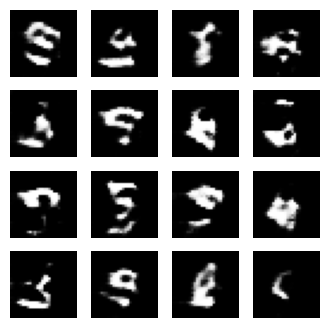

Time for epoch 18 is 10.42416501045227 sec


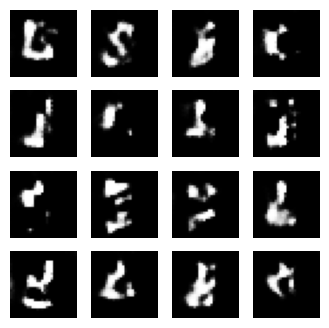

Time for epoch 19 is 10.336241722106934 sec


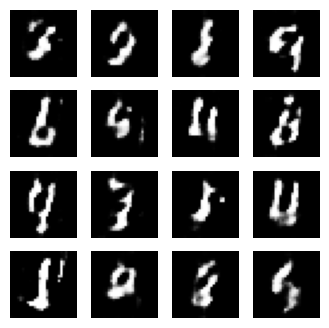

Time for epoch 20 is 10.440330266952515 sec


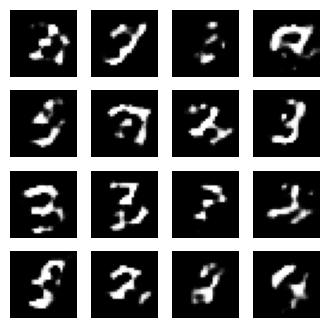

Time for epoch 21 is 10.42039680480957 sec


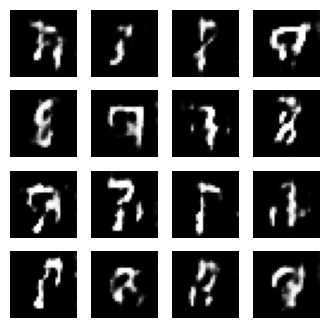

Time for epoch 22 is 10.35786771774292 sec


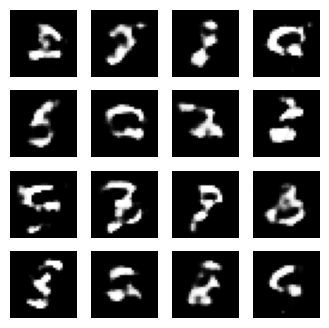

Time for epoch 23 is 10.353134870529175 sec


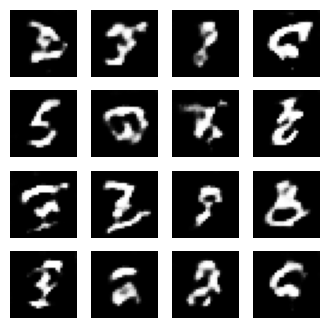

Time for epoch 24 is 10.486859798431396 sec


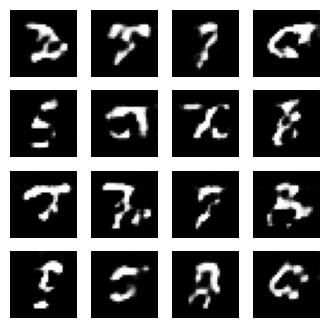

Time for epoch 25 is 10.511040210723877 sec


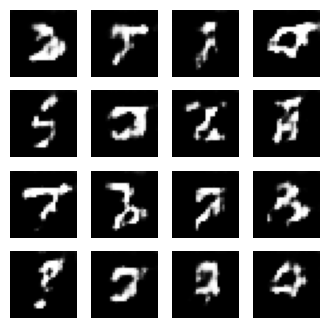

Time for epoch 26 is 10.403156995773315 sec


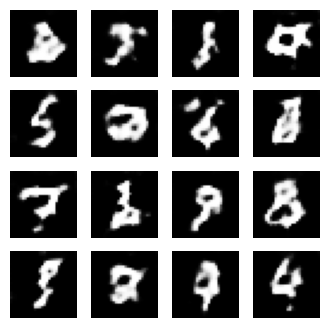

Time for epoch 27 is 10.429285287857056 sec


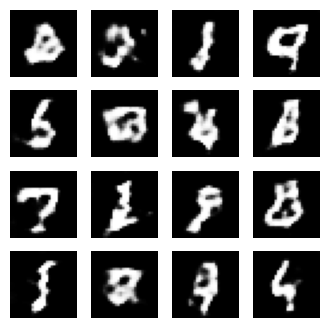

Time for epoch 28 is 10.341653823852539 sec


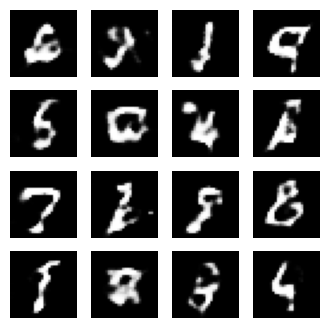

Time for epoch 29 is 10.342658519744873 sec


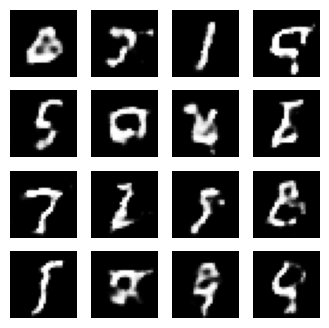

Time for epoch 30 is 10.529310464859009 sec


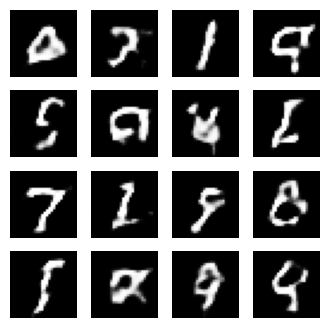

Time for epoch 31 is 10.338580131530762 sec


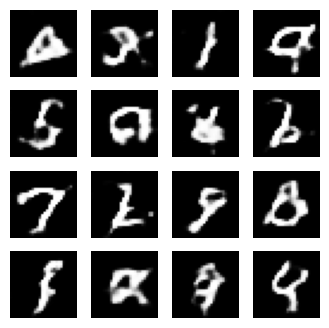

Time for epoch 32 is 10.337504863739014 sec


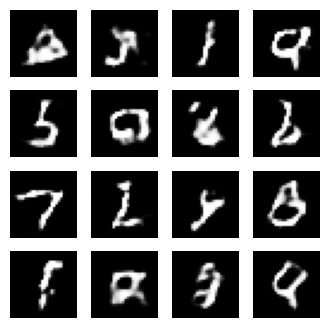

Time for epoch 33 is 10.434818506240845 sec


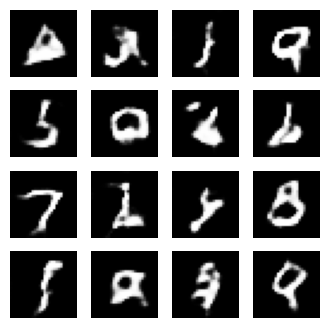

Time for epoch 34 is 10.3311607837677 sec


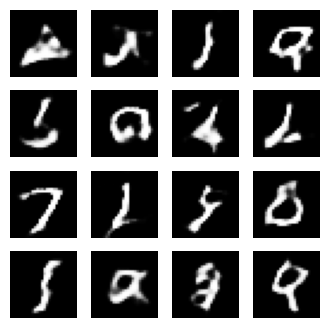

Time for epoch 35 is 10.331398248672485 sec


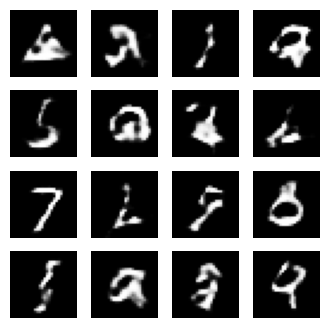

Time for epoch 36 is 10.380831718444824 sec


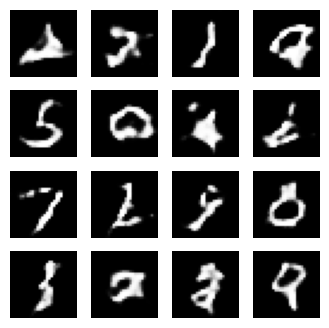

Time for epoch 37 is 10.50215196609497 sec


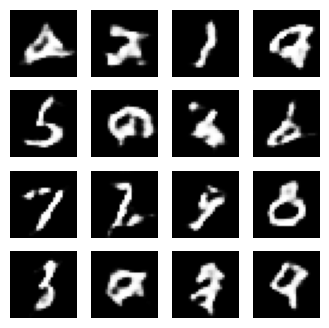

Time for epoch 38 is 10.36113953590393 sec


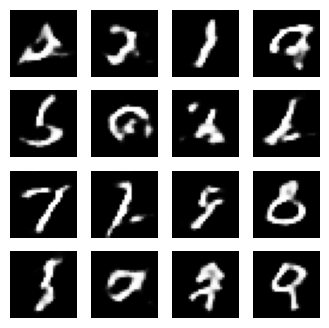

Time for epoch 39 is 10.346339225769043 sec


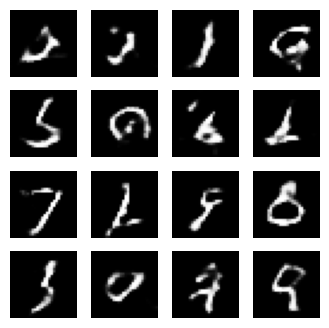

Time for epoch 40 is 10.430100440979004 sec


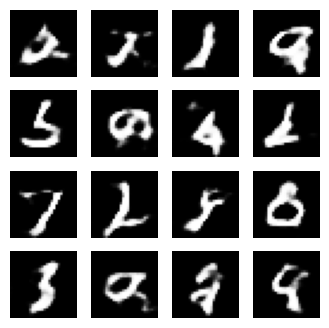

Time for epoch 41 is 10.472885370254517 sec


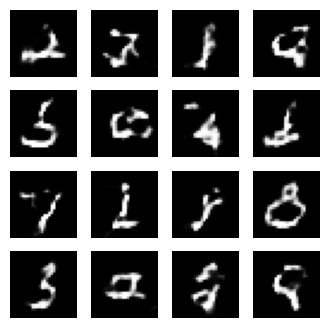

Time for epoch 42 is 10.449020862579346 sec


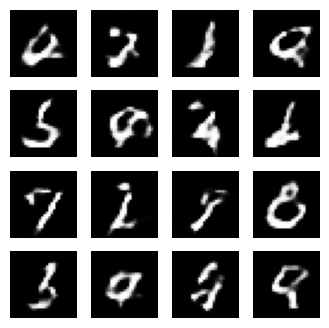

Time for epoch 43 is 10.540693998336792 sec


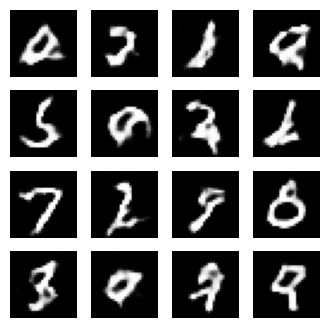

Time for epoch 44 is 10.463881015777588 sec


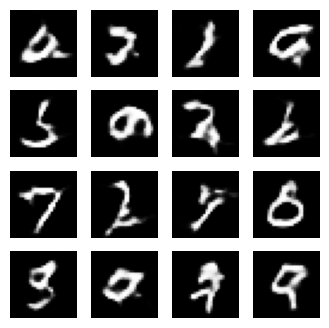

Time for epoch 45 is 10.594465017318726 sec


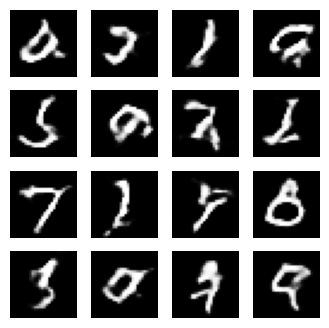

Time for epoch 46 is 10.583937406539917 sec


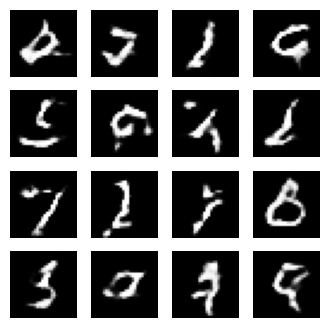

Time for epoch 47 is 10.444729566574097 sec


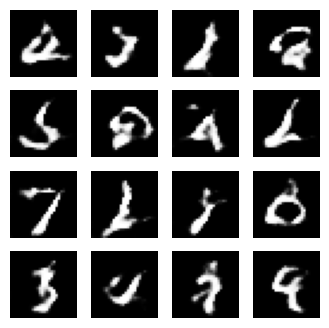

Time for epoch 48 is 10.425048351287842 sec


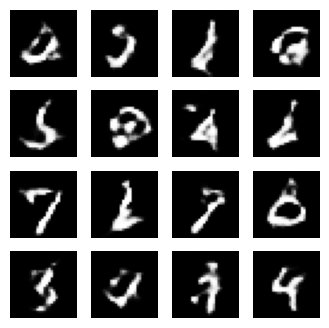

Time for epoch 49 is 10.425514936447144 sec


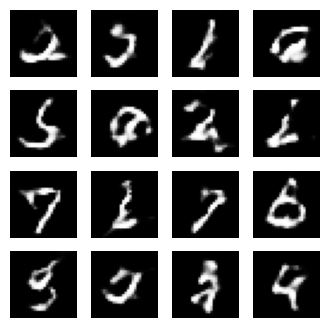

Time for epoch 50 is 10.551844596862793 sec


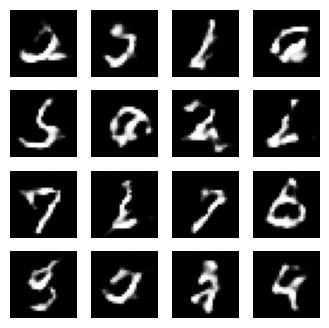

In [20]:
train(train_dataset, EPOCHS)

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

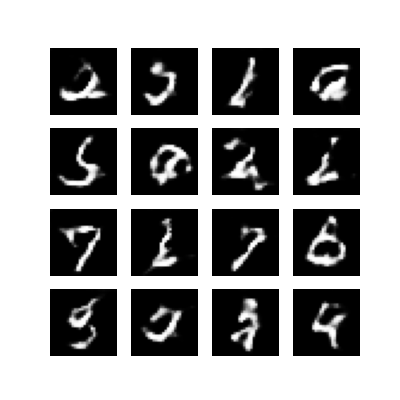

In [23]:
display_image(EPOCHS)

In [24]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\Inho Lee\AppData\Local\Temp\ipykernel_56936\3254420154.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Inho Lee\AppData\Local\Temp\ipykernel_56936\3254420154.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

In [26]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\inho lee\appdata\local\temp\pip-req-build-hpyvg4_j


  ERROR: Error [WinError 2] 지정된 파일을 찾을 수 없습니다 while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
